In [93]:
# Import dependencies
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.orm import Session
import datetime as dt
import matplotlib
#matplotlib.use('nbagg')
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt 

In [62]:
# Create the connection engine to the sqlite database
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [63]:
# Establish Base for which classes will be constructed 
Base = automap_base()

In [64]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [65]:
# Assign the demographics class to a variable called `Demographics`
Station = Base.classes.stations

In [66]:
# Assign the demographics class to a variable called `Demographics`
Measurement = Base.classes.measurements

In [67]:
# To push the objects made and query the server we use a Session object
session = Session(bind=engine)

In [95]:
# Show latest date in measurements table
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

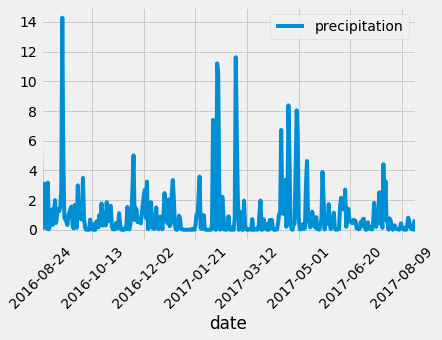

In [97]:
# Retrieve the last 12 months of precipitation data.
last_12_months = session.query(Measurement.date, func.sum(Measurement.precipitation))\
                    .filter(Measurement.date > '2016-08-23')\
                    .group_by(Measurement.date)\
                    .order_by(Measurement.date).all()
              
#Load the query results into a Pandas DataFrame and set the index to the date column. 
last_12_months_df = pd.DataFrame(last_12_months, columns=['date', 'precipitation'])
last_12_months_df = last_12_months_df.set_index('date')

#Plot the results using the DataFrame plot method.
last_12_months_df.plot()

# Rotate the xticks for the dates
plt.xticks(rotation='45')
plt.show() 

In [88]:
last_12_months_df.describe()

,precipitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000
